# Import Modules

In [16]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.manifold import TSNE
import torch
from torch import nn
from torch import optim

import utils

In [17]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Prepare Data

In [18]:
source_X, target_X, source_y_task, target_y_task, x_grid, x1_grid, x2_grid = utils.get_source_target()
source_loader, target_loader, source_y_task, source_X, target_X, target_y_task = utils.get_loader(source_X, target_X, source_y_task, target_y_task)

# Instantiate Feature Extractor, Domain Classifier, Task Classifier

In [19]:
hidden_size = 10
num_domains = 1
num_classes = 1
dropout_ratio = 0.5

feature_extractor = utils.Encoder(input_size=source_X.shape[1], output_size=hidden_size).to(device)
domain_classifier = utils.Decoder(input_size=hidden_size, output_size=num_domains).to(device)
task_classifier = utils.Decoder(input_size=hidden_size, output_size=num_classes).to(device)

In [20]:
learning_rate = 0.001

criterion = nn.BCELoss()
feature_optimizer = optim.Adam(feature_extractor.parameters(), lr=learning_rate)
domain_optimizer = optim.Adam(domain_classifier.parameters(), lr=learning_rate)
task_optimizer = optim.Adam(task_classifier.parameters(), lr=learning_rate)

# Domain Invariant Learning

In [21]:
reverse_grad = utils.ReverseGradient.apply
# TODO: Understand torch.autograd.Function.apply
num_epochs = 1000
loss_domains = []
loss_tasks = []

for _ in range(num_epochs):
    for (source_X_batch, source_Y_batch), (target_X_batch, target_y_domain_batch) in zip(source_loader, target_loader):
        # 0. Data
        source_X_batch = source_X_batch
        source_y_task_batch = source_Y_batch[:, 0]
        source_y_domain_batch = source_Y_batch[:, 1]
        target_X_batch = target_X_batch
        target_y_domain_batch = target_y_domain_batch

        # 1. Forward
        # 1.1 Feature Extractor
        source_X_batch, target_X_batch = feature_extractor(source_X_batch), feature_extractor(target_X_batch)

        # 1.2. Task Classifier
        pred_y_task = task_classifier(source_X_batch)
        pred_y_task = torch.sigmoid(pred_y_task).reshape(-1)
        loss_task = criterion(pred_y_task, source_y_task_batch)
        loss_tasks.append(loss_task.item())

        # 1.3. Domain Classifier
        source_X_batch, target_X_batch = reverse_grad(source_X_batch), reverse_grad(target_X_batch)
        pred_source_y_domain, pred_target_y_domain = domain_classifier(source_X_batch), domain_classifier(target_X_batch)
        pred_source_y_domain, pred_target_y_domain = torch.sigmoid(pred_source_y_domain).reshape(-1), torch.sigmoid(pred_target_y_domain).reshape(-1)

        loss_domain = criterion(pred_source_y_domain, source_y_domain_batch)
        loss_domain += criterion(pred_target_y_domain, target_y_domain_batch)
        loss_domains.append(loss_domain.item())

        # 2. Backward, Update Params
        domain_optimizer.zero_grad()
        task_optimizer.zero_grad()
        feature_optimizer.zero_grad()

        loss_domain.backward(retain_graph = True)
        loss_task.backward() 
        
        domain_optimizer.step()
        task_optimizer.step()
        feature_optimizer.step()
    # 3. Evaluation
    # TODO: trace loss_task for target

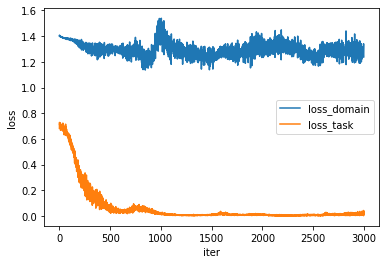

In [22]:
plt.plot(loss_domains, label="loss_domain")
plt.plot(loss_tasks, label="loss_task")
plt.xlabel("iter")
plt.ylabel("loss")
plt.legend()

# Domain Adaptation Accuracy

In [23]:
target_feature_eval = feature_extractor(target_X)
pred_y_task = task_classifier(target_feature_eval)
pred_y_task = torch.sigmoid(pred_y_task).reshape(-1)
pred_y_task = pred_y_task > 0.5

acc = sum(pred_y_task == target_y_task) / target_y_task.shape[0]
print(f"Accuracy:{acc}")

Accuracy:0.9399999976158142


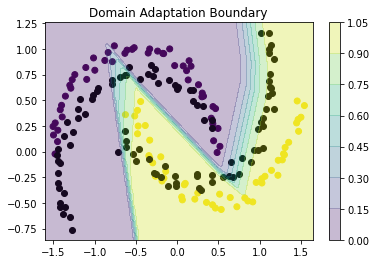

In [24]:
source_X = source_X.cpu()
target_X = target_X.cpu()

x_grid = torch.tensor(x_grid, dtype=torch.float32)
x_grid = x_grid.to(device)

x_grid_feature = feature_extractor(x_grid.T)
y_grid = task_classifier(x_grid_feature)
y_grid = torch.sigmoid(y_grid)
y_grid = y_grid.cpu().detach().numpy()

plt.title("Domain Adaptation Boundary")
plt.scatter(source_X[:, 0], source_X[:, 1], c=source_y_task)
plt.scatter(target_X[:, 0], target_X[:, 1], c="black")
plt.contourf(x1_grid, x2_grid, y_grid.reshape(100, 100), alpha=0.3)
plt.colorbar()

# Without Adaptation

In [25]:
task_classifier = utils.Decoder(input_size=2, output_size=num_classes).to(device)
task_optimizer = optim.Adam(task_classifier.parameters(), lr=learning_rate)

In [26]:
for _ in range(num_epochs):
    for source_X_batch, source_Y_batch in source_loader:
        # Prep Data
        source_X_batch = source_X_batch
        source_y_task_batch = source_Y_batch[:, 0]
        
        # Forward
        pred_y_task = task_classifier(source_X_batch)
        pred_y_task = torch.sigmoid(pred_y_task).reshape(-1)
        loss_task = criterion(pred_y_task, source_y_task_batch)
        
        # Backward
        task_optimizer.zero_grad()
        loss_task.backward()

        # Updata Params
        task_optimizer.step()

In [27]:
pred_y_task = task_classifier(target_X.to(device))
pred_y_task = torch.sigmoid(pred_y_task).reshape(-1)
pred_y_task = pred_y_task > 0.5
acc = sum(pred_y_task == target_y_task) / target_y_task.shape[0]
print(f"Without Adaptation Accuracy:{acc}")

Without Adaptation Accuracy:0.7999999523162842


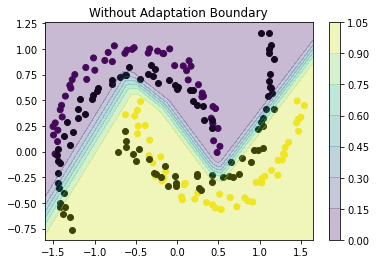

In [28]:
y_grid = task_classifier(x_grid.T)
y_grid = torch.sigmoid(y_grid)
y_grid = y_grid.cpu().detach().numpy()

plt.title("Without Adaptation Boundary")
plt.scatter(source_X[:, 0], source_X[:, 1], c=source_y_task)
plt.scatter(target_X[:, 0], target_X[:, 1], c="black")
plt.contourf(x1_grid, x2_grid, y_grid.reshape(100, 100), alpha=0.3)
plt.colorbar()

# t-SNE Visualization for Extracted Feature

In [29]:
tsne = TSNE(n_components=2, learning_rate='auto', init='random', perplexity=3)
# TODO: Understand Argumetns for t-SNE

target_feature_eval = target_feature_eval.cpu().detach().numpy()
source_X = source_X.to(device)
source_feature = feature_extractor(source_X)
source_feature = source_feature.cpu().detach().numpy()

target_feature_tsne = tsne.fit_transform(target_feature_eval)
source_feature_tsne = tsne.fit_transform(source_feature)
# TODO: Understand t-SNE Algo 

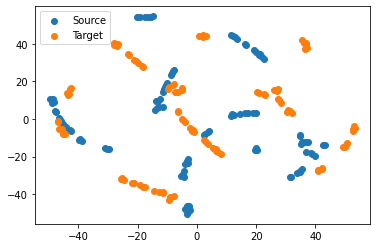

In [30]:
plt.scatter(source_feature_tsne[:, 0], source_feature_tsne[:, 1], label="Source")
plt.scatter(target_feature_tsne[:, 0], target_feature_tsne[:, 1], label="Target")
plt.legend()